# K Fold CV Experimentation on Ridge Regression

The goal of this mini project is to experiment with the `K-fold cross validation (CV)` procedure to tune the penalty parameter `λ` in Ridge regression, without using any pre-defined packages from libraries like `scikit-learn`.

## Background on Ridge Regression and `MAP` estimate

In linear regression, we suppose that $\mathbf{X} \in \mathbf{R}^{n\times m}$ with $n ≥ m$ and $t ∈ \mathbf{R}^n$, and that  $\mathbf{t}|(\mathbf{X}, \mathbf{w}) \sim \mathbf{N}(\mathbf{Xw}, \sigma^2\mathbf{I})$. We know that the maximum likelihood estimate $\hat{\mathbf{w}}$ of $\mathbf{w}$ is given by $\hat{\mathbf{w}} = (X^TX)^{-1}X^Tt$.

Now, suppose we place a normal prior on $\mathbf{w}|\mathbf{X}$, i.e., $\mathbf{w} \sim \mathbf{N}(0,\tau^2\mathbf{I})$. 
Then, the `MAP` (Maximum a posteriori) estimate  of $\mathbf{w}$ is given as the maximum of the posterior density:

$$\hat{\mathbf{w}}_{MAP} = \underset{\mathbf{w}}{\text{argmax}}\{p(\mathbf{w}|\mathbf{X}, \mathbf{t}) \propto p(\mathbf{t}|\mathbf{X}, \mathbf{w})p(\mathbf{w}|\mathbf{X})\}$$

(Note that we use the $\propto$ notation here to mean "proportional to", since we dropped the term $p(t|X)$ in the denominator as it doesn’t have $w$ in it, and thus doesn't contribute to the maximization problem.)

By taking the log-likelihood and setting the derivative to 0, the `MAP` estimate of $w$ given $(t, X)$ will be given as:

$$\hat{\mathbf{w}}_{MAP} = (X^TX+\lambda I)^{-1}X^Tt$$  where $\lambda = \frac{\sigma^2}{\gamma^2}$. We will use this as the coefficients of the ridge regression with penalty level $\lambda$ in the implementation of CV below with the function `train_model`.

## Procedure

1. First we will set aside a test dataset and never use it until the training and parameter tuning procedures are complete. We will use this data for final evaluation. Test data is used as a separate dataset.
2. Use the CV error to estimate the test error of a particular hyperparameter choice. For a particular hyperparameter value, we will split the training data into K blocks, and for k = 1, 2, ..., K we will use the k-th block for validation and the remaining K − 1 blocks for training. Therefore, we will train and validate our algorithm K times. The CV estimate for the test error for that particular hyperparameter choice is given by the average validation error across these K blocks.
3. Repeat the above procedure for several hyperparameter choices and choose the one that provides us with the smalles CV error (which is an estimate for the test error).

The `data` we will use is a variable and refers to a (`t`, `X`) pair (in test, training, or validation sets) where `t` is the target (response) vector, and `X` is the feature matrix.
`model` is a variable and refers to the coefficients of the trained model, i.e. $\hat{w}_{\lambda}$.

## Implementation

The function `shuffle_data(data)` will take data as an argument and returns its randomly permuted version along the samples. We will use a uniformly random permutation of the training data and note that `t` and `X` will be permuted the same way preserving the target-feature pairs.

In [1]:
def shuffle_data(data):
    np.random.shuffle(data)
    return data

The function `split_data(data, num_folds, fold)` is a function that takes data, number of partitions as `num_folds` and the selected partition fold as its arguments and returns the selected partition (block) fold as `data_fold`, and the remaining data as `data_rest`. In other words, if we consider 5-fold cross validation, `num_folds=5`, the function will split the data into 5 blocks and returns the block $fold \in {1, 2, 3, 4, 5})$ as the validation fold and the remaining 4 blocks as data_rest. Note that `data_rest` $\cup$ `data_fold = data`, and `data_rest` $\cap$ `data_fold` $= \emptyset$.

In [2]:
def split_data(data, num_folds, fold): #data is [(2, array([2,3,4])), array((b, [1,2,3]))] #fold = 1,2,3..
    data_rest = []
    data_fold = []
    slicing = len(data) / num_folds
    for i in range(len(data)):
        if i != (fold): 
            data_rest.extend(data[int(i*slicing):int((i+1)*slicing)])
        else:
            data_fold.extend(data[int(i*slicing):int((i+1)*slicing)])
    return data_fold, data_rest

The function `train_model(data, lambd)` takes data and lambd as its arguments, and returns the coefficients of ridge regression with penalty level $λ$, using the expression we derived above.

In [4]:
def train_model(data, lambd):
    X = []
    t = []
    
    for i in range(len(data)):
        X.append(data[i][1])
        t.append(data[i][0])
    X = np.array(X)
    t = np.array(t)
    X_transpose = X.transpose()
    return (np.linalg.inv(X_transpose.dot(X) + lambd * np.identity(X.shape[1])).dot(X_transpose)).dot(t)

The function `predict(data, model)` is a function that takes data and model as its arguments, and returns the predictions based on data and model.

In [5]:
def predict(data, model):
    X = []
    t = []
    for i in range(len(data)):
        X.append(data[i][1])
        t.append(data[i][0])
    X_np = np.array(X)
    return np.dot(X_np, model)

The function `loss(data, model)` takes data and model as its arguments and returns the average squared error loss based on model. This means if data is composed of $t \in R^n$ and $X \in R^{n \times p}$ and the model is $\hat{\mathbf{w}}$ , then the return value will be $||t - X\hat{\mathbf{w}}||^2/n$.

In [6]:
def loss(data, model):
    X = []
    t = []
    n = len(data)
    for i in range(len(data)):
        X.append(data[i][1])
        t.append(data[i][0])
    X = np.array(X)
    t = np.array(t)
    prediction = predict(data, model)
    error = (np.linalg.norm(t - prediction ,2) **2)/n
    return error

The function `cross_validation(data, num_folds, lambd_seq)` takes the training data, number of folds num_folds, and a sequence of $\lambda$'s as `lambd_seq` as its arguments and returns the cross validation error across all $\lambda$'s. If we take `lambd_seq` as evenly spaced 50 numbers over the interval (0.02, 1.5). This means `cv_error` will be a vector of 50 errors corresponding to the values of `lambd_seq`. 

In [7]:
def cross_validation(data, num_folds, lambd_seq):
    data = shuffle_data(data)
    cv_error = []
    for i in range(len(lambd_seq)):
        lambd = lambd_seq[i]
        cv_loss_lmd = 0
        for fold in range(num_folds):
            val_cv, train_cv = split_data(data, num_folds, fold)
            model = train_model(train_cv, lambd)      
            cv_loss_lmd += loss(val_cv, model)
        cv_error.append(cv_loss_lmd / num_folds)
    return cv_error

## Execution 

In [19]:
#setup
import matplotlib. pyplot as plt
import numpy as np

data_train = {'X': np.genfromtxt('data_train_X.csv', delimiter= ','),
                                 't': np.genfromtxt('data_train_y.csv', delimiter=',')}
data_test = {'X': np.genfromtxt('data_test_X.csv', delimiter= ','),
                                 't': np.genfromtxt('data_test_y.csv', delimiter=',')}

t_train = data_train['t']
X_train = data_train['X']
t_test = data_test['t']
X_test = data_test['X']

data_train_ = []
for i in range(len(t_train)):
    data_train_.append((t_train[i], X_train[i]))

data_test_ = []
for i in range(len(t_test)):
    data_test_.append((t_test[i], X_test[i]))

Initialize a `lambd_seq` amd find the training and test errors corresponding to each $\lambda$ in `lambd_seq`.

In [12]:
lambd_seq = np.linspace (0.02 , 1.5 , num =50)
lambd_seq

array([0.02      , 0.05020408, 0.08040816, 0.11061224, 0.14081633,
       0.17102041, 0.20122449, 0.23142857, 0.26163265, 0.29183673,
       0.32204082, 0.3522449 , 0.38244898, 0.41265306, 0.44285714,
       0.47306122, 0.50326531, 0.53346939, 0.56367347, 0.59387755,
       0.62408163, 0.65428571, 0.6844898 , 0.71469388, 0.74489796,
       0.77510204, 0.80530612, 0.8355102 , 0.86571429, 0.89591837,
       0.92612245, 0.95632653, 0.98653061, 1.01673469, 1.04693878,
       1.07714286, 1.10734694, 1.13755102, 1.1677551 , 1.19795918,
       1.22816327, 1.25836735, 1.28857143, 1.31877551, 1.34897959,
       1.37918367, 1.40938776, 1.43959184, 1.46979592, 1.5       ])

In [20]:
training_data = shuffle_data(data_train_)
testing_data = shuffle_data(data_test_)  
training_error_list = []
testing_error_list = []

five_fold_error = cross_validation(training_data, 5, lambd_seq)
ten_fold_error = cross_validation(training_data, 10, lambd_seq)

for lambd in lambd_seq:
    model = train_model(training_data, lambd)
    training_error = loss(training_data, model)
    training_error_list.append(training_error)
    testing_error = loss(testing_data, model)
    testing_error_list.append(testing_error)

    print("training error is "+ str(training_error) + " for lamda = " +str (lambd))
    print("testing error is "+ str(testing_error) + " for lamda = " +str (lambd)+"\n")

training error is 0.049736491547443556 for lamda = 0.02
testing error is 5.106959783590839 for lamda = 0.02

training error is 0.10583474384162299 for lamda = 0.050204081632653066
testing error is 3.6308336211216363 for lamda = 0.050204081632653066

training error is 0.1539702959791624 for lamda = 0.08040816326530613
testing error is 3.070316730406794 for lamda = 0.08040816326530613

training error is 0.19754784437778394 for lamda = 0.11061224489795919
testing error is 2.770942353158946 for lamda = 0.11061224489795919

training error is 0.23812998498606192 for lamda = 0.14081632653061224
testing error is 2.5873531089834767 for lamda = 0.14081632653061224

training error is 0.2765778425897501 for lamda = 0.1710204081632653
testing error is 2.46600554123685 for lamda = 0.1710204081632653

training error is 0.3134077787636036 for lamda = 0.20122448979591837
testing error is 2.3821345226047588 for lamda = 0.20122448979591837

training error is 0.34894854455537194 for lamda = 0.231428571428

Plot training error, test error, and 5-fold and 10-fold cross validation errors on the same plot for each value in `lambd_seq`.

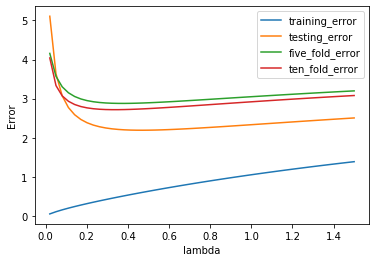

In [32]:
plt.plot(lambd_seq, training_error_list, label='training_error') 
plt.plot(lambd_seq, testing_error_list, label='testing_error')
plt.plot(lambd_seq, five_fold_error, label='five_fold_error') 
plt.plot(lambd_seq, ten_fold_error, label='ten_fold_error')
plt.ylabel("Error")
plt.xlabel("lambda")
plt.legend()
plt.savefig("final_plot.png")

In [28]:
min_five_fold = min(five_fold_error)
min_ten_fold = min(ten_fold_error)
print("Lambda value proposed by 5-fold cv is: " + str(lambd_seq[five_fold_error.index(min_five_fold)]) + 
      " having a cv error of " + str(min_five_fold))
print("Lambda value proposed by 10-fold cv is: " + str(lambd_seq[ten_fold_error.index(min_ten_fold)]) + 
      " having a cv error of " + str(min_ten_fold))

Lambda value proposed by 5-fold cv is: 0.38244897959183677 having a cv error of 2.8770597183858024
Lambda value proposed by 10-fold cv is: 0.32204081632653064 having a cv error of 2.716745953633525


Based on the graph, the `training error` is the only function that seems to increase steadily as `lambda`
increases (perhaps even exponentially, if we only consider the scale of this graph). We can also see
that the training error is extremely low for small lambda, which is the exact opposite for the other 3
errors. For `testing`, 5-fold, and 10-fold errors, the errors originally start off at a very high error rate,
but significantly decrease between 0 to 0.2 lambda, then it comes to a gradual increase.
While the gap between 10-fold and 5-fold errors didn’t differ by a significant amount, we can see that
5-fold error performed consistently better than both both the testing and 10-fold errors. This is due
to the fact that when `lambda` increases in ridge regression, the variance decreases but the bias will in
turn increase